In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError



def data_prep(start_date, end_date):
    df = yf.download('AMZN',start_date,end_date)
    APPL = yf.download('AAPL',start_date,end_date)
    MSFT = yf.download('MSFT',start_date,end_date)
    GOOG = yf.download('GOOG',start_date,end_date)
    VIX = yf.download("^VIX", start_date,end_date)
    usdx = yf.download('DX-Y.NYB', start_date,end_date)


    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['APPL'] = APPL['Close']
    df['MSFT'] = MSFT['Close']
    df['GOOG'] = GOOG['Close']
    df['VIX'] = VIX['Close']
    df['USDX'] = usdx['Close']

    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    histogram = macd - signal

    df['EMA12'] = ema12
    df['EMA26'] = ema26
    df['MACD'] = macd
    df['MACD_signal'] = signal
    df['MACD_hist'] = histogram

    print(df.info)
    df.columns = df.columns.str.replace(' ','_')
    df = df.dropna()
    df.drop(['Open', 'High', 'Low', 'Adj_Close'], axis=1, inplace=True)
    y_data = df['Close']
    df.drop(['Close'], axis=1, inplace=True)
    dates = pd.DataFrame(df.index)
    X_data = df
    return X_data,y_data, dates

start_date = '2022-04-01'
end_date = '2023-03-31'
X, y,dates = data_prep(start_date, end_date)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and y.shape[0] > 0:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    print("Insufficient data for MinMaxScaler")






[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method DataFrame.info of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-01  164.149506  165.826996  162.319504  163.559998  163.559998   
2022-04-04  164.125000  168.394501  163.205505  168.346497  168.346497   
2022-04-05  167.741501  168.110504  163.266006  164.054993  164.054993   
2022-04-06  161.650497  162.199997  157.254501  158.755997  158.755997   
2022-04-07  158.399994  160.078995  154.511505  157.784500  157.784500   
...                ...         ...  

In [59]:
dates

,Date
0,2022-04-21
1,2022-04-22
2,2022-04-25
3,2022-04-26
4,2022-04-27
...,...
232,2023-03-24
233,2023-03-27
234,2023-03-28
235,2023-03-29


In [32]:
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_Y, test_Y = y[:train_size], y[train_size:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2
]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss=MeanSquaredError(), optimizer=Adam())


In [39]:
import matplotlib.pyplot as plt


print(X.shape)
print()

(237, 12)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(train_X, train_Y, epochs=100, batch_size=16, validation_data=(test_X, test_Y), callbacks=[early_stop], verbose=2, shuffle=False)

test_loss = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict(test_X)

yhat = y_scaler.inverse_transform(yhat)
test_Y = y_scaler.inverse_transform(test_Y)

print('Test loss: ', test_loss)

mae = mean_absolute_error(test_Y, yhat)
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
r2 = r2_score(test_Y, yhat)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('R²: ', r2)

In [34]:
n_future_days = 10
predictions = []

for i in range(n_future_days):
    input_data = test_X[-1].reshape((1, test_X.shape[1], test_X.shape[2]))
    next_day_predicted_price_scaled = model.predict(input_data)
    next_day_predicted_price = y_scaler.inverse_transform(next_day_predicted_price_scaled)
    predictions.append(next_day_predicted_price[0][0])

    input_data[0, 0, :-1] = next_day_predicted_price_scaled[0, 0]
    test_X = np.concatenate((test_X, input_data))
print(f"Predicted closing prices for the next {n_future_days} days: {predictions}")

1/1 [==============================] - 0s 31ms/step
Predicted closing prices for the next 10 days: [103.92395, 104.052925, 104.216415, 104.42405, 104.688324, 105.02567, 105.45788, 106.014206, 106.734535, 107.67432]


In [35]:
import pickle

# Save the model to a file
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the MinMaxScaler objects for X and y
with open('x_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)


C:\Users\user\AppData\Local\Temp\ipykernel_11292\1256858817.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(last_date, periods=n_future_days + 1, closed='right')


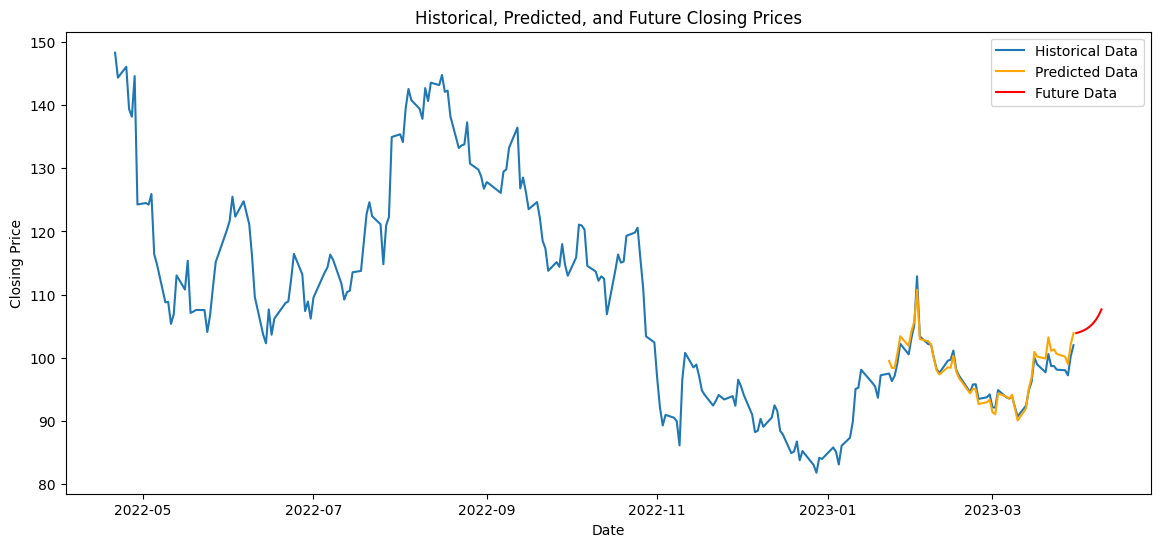

In [63]:
last_date = dates.iloc[-1].values[0]
future_dates = pd.date_range(last_date, periods=n_future_days + 1, closed='right')
future_prices = pd.DataFrame(predictions, columns=['Predicted Close'], index=future_dates)


plt.figure(figsize=(14, 6))
plt.plot(dates, y_scaler.inverse_transform(y), label='Historical Data')
plt.plot(dates.iloc[-yhat.shape[0]:], yhat, label='Predicted Data', color='orange')
plt.plot(future_prices.index, future_prices['Predicted Close'], label='Future Data', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical, Predicted, and Future Closing Prices')
plt.legend()
plt.show()


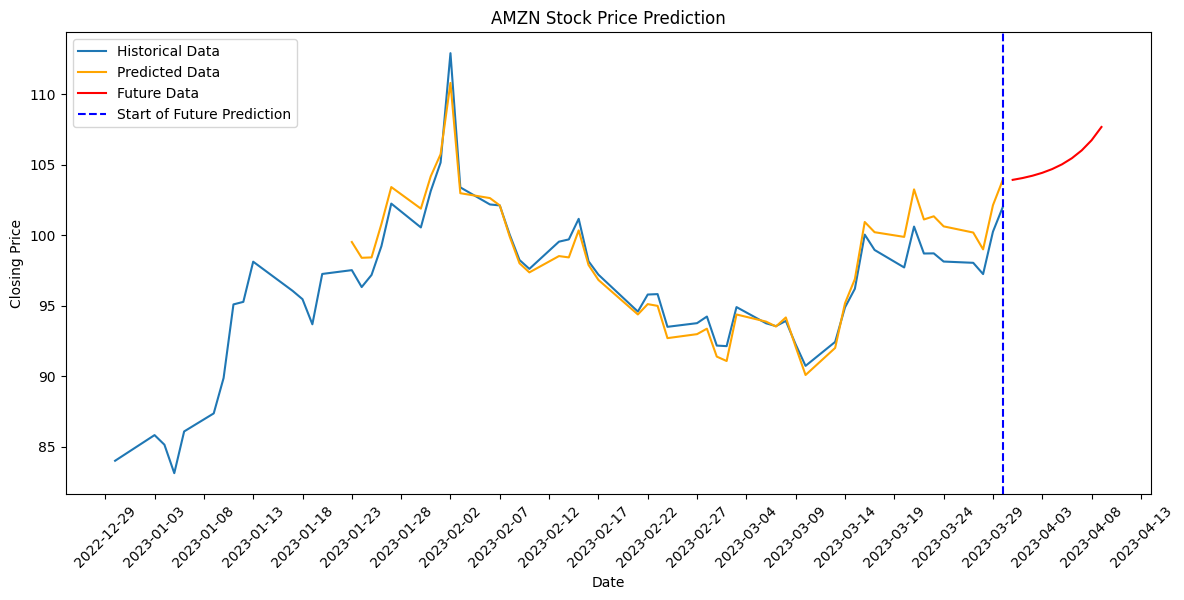

In [72]:
import matplotlib.dates as mdates

# Filter the data for the last 3 months
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1), :]

# Filter the predicted data
predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date
filtered_yhat = yhat[predicted_mask]
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

plt.figure(figsize=(14, 6))
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data')
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange')
plt.plot(future_prices.index, future_prices['Predicted Close'], label='Future Data', color='red')

# Draw a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction')

# Display day-by-day dates on the x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()
